# Workflow Debugging

In [ ]:
from predictor.driver import Predictor
from predictor.src import utils

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


(
    training_data,
    names_list,
    scores_list,
) = Predictor.generate_trainingdata_from_qasm_files(
    folder_path="qasm_files/"  # , compiled_path="qasm_compiled_postprocessed/"
)

In [ ]:
X, y = zip(*training_data)
Predictor.train_decision_tree_classifier(X, y, names_list, scores_list);

In [ ]:
from numpy import asarray
from numpy import save

data = asarray(training_data)
save("training_data.npy", data)
data = asarray(names_list)
save("names_list.npy", data)
data = asarray(scores_list)
save("scores_list.npy", data)

In [ ]:
from numpy import asarray
from numpy import save
from predictor.driver import Predictor
from predictor.src import utils

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

training_data = np.load("training_data.npy", allow_pickle=True)

names_list = list(np.load("names_list.npy", allow_pickle=True))

scores_list = list(np.load("scores_list.npy", allow_pickle=True))
X, y = zip(*training_data)
X = list(X)
y = list(y)
for i in range(len(X)):
    X[i] = list(X[i])
    scores_list[i] = list(scores_list[i])

In [ ]:
Predictor.train_decision_tree_classifier(X, y, names_list, scores_list);

# Decision Path Generation

In [ ]:
names_list[30]

In [ ]:
non_zero_indices = []
X = np.array(X)
y = np.array(y)
for i in range(len(X[0])):
    if sum(X[:, i]) > 0:
        non_zero_indices.append(i)
X = X[:, non_zero_indices]

openqasm_qc_list = utils.get_openqasm_gates()
res = [openqasm_qc_list[i] for i in range(0, len(openqasm_qc_list))]
res.append("num_qubits")
res.append("depth")
for i in range(1, 6):
    res.append(str(i) + "_max_interactions")

res = [res[i] for i in non_zero_indices]
index = 30
X_test = X[[index]]

clf_instance = Predictor._clf.best_estimator_
n_nodes = clf_instance.tree_.node_count
children_left = clf_instance.tree_.children_left
children_right = clf_instance.tree_.children_right
feature = clf_instance.tree_.feature
threshold = clf_instance.tree_.threshold
node_indicator = clf_instance.decision_path(X_test)
leaf_id = clf_instance.apply(X_test)

sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print("Rules used to predict sample {id}:\n".format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue
    # check if value of the split feature for sample 0 is below threshold
    if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=res[feature[node_id]],
            value=X_test[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )
print("Prediction: ", clf_instance.predict(X_test))

In [ ]:
(
    X_train,
    X_test,
    y_train,
    y_test,
) = train_test_split(X, y, test_size=0.3, random_state=5)
for i in range(19):
    print(y_test.count(i), utils.get_machines()[i])

In [ ]:
print(node_indicator)

# Debugging

In [ ]:
machines = utils.get_machines()
[machines[i] for i in list(Predictor._clf.classes_)]

In [ ]:
from qiskit import QuantumCircuit
from mqt.bench import get_one_benchmark

qc = get_one_benchmark("ghz", 1, 5)

# Nachbehandlung OQC qasm files

In [ ]:
import os
from qiskit import QuantumCircuit

directory = "qasm_compiled"
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if "oqc_qiskit" in f:
        with open(f, "r") as f:
            lines = f.readlines()
        new_name = os.path.join("qasm_compiled_postprocessed", filename)
        with open(new_name, "w") as f:
            for line in lines:
                if not (
                    "gate rzx" in line.strip("\n") or "gate ecr" in line.strip("\n")
                ):
                    f.write(line)
                if "gate ecr" in line.strip("\n"):
                    f.write(
                        "gate rzx(param0) q0,q1 { h q1; cx q0,q1; rz(param0) q1; cx q0,q1; h q1; }\n"
                    )
                    f.write(
                        "gate ecr q0,q1 { rzx(pi/4) q0,q1; x q0; rzx(-pi/4) q0,q1; }\n"
                    )

        qc = QuantumCircuit.from_qasm_file(new_name)
        print("New qasm file for: ", new_name)

    elif "oqc_tket" in f:
        with open(f, "r") as f:
            lines = f.readlines()
        new_name = os.path.join("qasm_compiled_postprocessed", filename)
        with open(new_name, "w") as f:
            count = 0
            for line in lines:
                f.write(line)
                count += 1
                if count == 2:
                    f.write(
                        "gate rzx(param0) q0,q1 { h q1; cx q0,q1; rz(param0) q1; cx q0,q1; h q1; }\n"
                    )
                    f.write(
                        "gate ecr q0,q1 { rzx(pi/4) q0,q1; x q0; rzx(-pi/4) q0,q1; }\n"
                    )
        qc = QuantumCircuit.from_qasm_file(new_name)
        print("New qasm file for: ", new_name)

# Nachbehandlung: Check if File is readable at all

In [ ]:
import os
from qiskit import QuantumCircuit

directory = "qasm_compiled"
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if f.endswith(".qasm"):
        try:
            qc = QuantumCircuit.from_qasm_file(f)
        except Exception as e:
            print("Fail: ", e)
            # Delete file: os.remove(f)

In [ ]:
import glob

files = glob.glob("qasm_compiled/ae_indep_2_*")
print(files)

In [ ]:
np.median([i for i in range(1, 20)])

# Debugging MQT Bench Integration

In [2]:
from predictor.driver import Predictor
from predictor.src import utils
from mqt.bench import get_one_benchmark
from qiskit import QuantumCircuit

In [3]:
Predictor.save_all_compilation_path_results(
    source_path="./comp_test_source", target_path="./comp_test", timeout=5
)
utils.postprocess_ocr_qasm_files(directory="./comp_test")
(
    training_data,
    names_list,
    scores_list,
) = Predictor.generate_trainingdata_from_qasm_files(
    source_path="./comp_test_source", target_path="./comp_test/"
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done   3 out of  21 | elapsed:   10.6s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   4 out of  21 | elapsed:   13.2s remaining:   56.0s
[Parallel(n_jobs=-1)]: Done   5 out of  21 | elapsed:   14.3s remaining:   45.7s
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:   15.5s remaining:   38.8s
[Parallel(n_jobs=-1)]: Done   7 out of  21 | elapsed:   16.5s remaining:   33.1s
[Parallel(n_jobs=-1)]: Done   8 out of  21 | elapsed:   16.6s remaining:   27.0s
[Parallel(n_jobs=-1)]: Done   9 out of  21 | elapsed:   16.7s remaining:   22.3s
[Parallel(n_jobs=-1)]: Done  10 out of  21 | elapsed:   18.3s remaining:   20.2s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:   18.4s remaining:   16.7s
[Parallel(n_jobs=-1)]: Done  12 out of  21 | elapsed:   22.2s remainin

New qasm file for:  ./comp_test/ae_indep_qiskit_5_26.qasm
portfoliovqe_indep_qiskit_5_15.qasm
comp_path_index:  15
realamprandom_indep_qiskit_5_13.qasm
comp_path_index:  13
vqe_indep_qiskit_5_23.qasm
comp_path_index:  23
qftentangled_indep_qiskit_5_20.qasm
comp_path_index:  20
dj_indep_qiskit_5_9.qasm
comp_path_index:  9
pricingput_indep_qiskit_5_16.qasm
comp_path_index:  16
qaoa_indep_qiskit_5_18.qasm
comp_path_index:  18
qpeexact_indep_qiskit_5_19.qasm
comp_path_index:  19
twolocalrandom_indep_qiskit_5_17.qasm
comp_path_index:  17
ghz_indep_qiskit_5_2.qasm
comp_path_index:  2
qgan_indep_qiskit_5_19.qasm
comp_path_index:  19
pricingput_indep_qiskit_5_3.qasm
comp_path_index:  3
ghz_indep_qiskit_5_21.qasm
comp_path_index:  21
dj_indep_qiskit_5_24.qasm
comp_path_index:  24
New qasm file for:  ./comp_test/dj_indep_qiskit_5_24.qasm
grover-noancilla_indep_qiskit_5_16.qasm
comp_path_index:  16
portfolioqaoa_indep_qiskit_5_5.qasm
comp_path_index:  5
vqe_indep_qiskit_5_19.qasm
comp_path_index:

New qasm file for:  ./comp_test/qpeexact_indep_qiskit_5_25.qasm
hhl_indep_qiskit_5_21.qasm
comp_path_index:  21
portfoliovqe_indep_qiskit_5_29.qasm
comp_path_index:  29
New qasm file for:  ./comp_test/portfoliovqe_indep_qiskit_5_29.qasm
qwalk-v-chain_indep_qiskit_5_24.qasm
comp_path_index:  24
New qasm file for:  ./comp_test/qwalk-v-chain_indep_qiskit_5_24.qasm
wstate_indep_qiskit_5_12.qasm
comp_path_index:  12
dj_indep_qiskit_5_18.qasm
comp_path_index:  18
realamprandom_indep_qiskit_5_8.qasm
comp_path_index:  8
su2random_indep_qiskit_5_22.qasm
comp_path_index:  22
qgan_indep_qiskit_5_25.qasm
comp_path_index:  25
New qasm file for:  ./comp_test/qgan_indep_qiskit_5_25.qasm
qpeinexact_indep_qiskit_5_26.qasm
comp_path_index:  26
New qasm file for:  ./comp_test/qpeinexact_indep_qiskit_5_26.qasm
su2random_indep_qiskit_5_0.qasm
comp_path_index:  0
wstate_indep_qiskit_5_24.qasm
comp_path_index:  24
New qasm file for:  ./comp_test/wstate_indep_qiskit_5_24.qasm
qwalk-v-chain_indep_qiskit_5_12.q

New qasm file for:  ./comp_test/grover-noancilla_indep_qiskit_5_29.qasm
twolocalrandom_indep_qiskit_5_28.qasm
comp_path_index:  28
New qasm file for:  ./comp_test/twolocalrandom_indep_qiskit_5_28.qasm
qgan_indep_qiskit_5_26.qasm
comp_path_index:  26
New qasm file for:  ./comp_test/qgan_indep_qiskit_5_26.qasm
su2random_indep_qiskit_5_21.qasm
comp_path_index:  21
qpeinexact_indep_qiskit_5_25.qasm
comp_path_index:  25
New qasm file for:  ./comp_test/qpeinexact_indep_qiskit_5_25.qasm
hhl_indep_qiskit_5_8.qasm
comp_path_index:  8
qpeinexact_indep_qiskit_5_24.qasm
comp_path_index:  24
New qasm file for:  ./comp_test/qpeinexact_indep_qiskit_5_24.qasm
hhl_indep_qiskit_5_9.qasm
comp_path_index:  9
twolocalrandom_indep_qiskit_5_29.qasm
comp_path_index:  29
New qasm file for:  ./comp_test/twolocalrandom_indep_qiskit_5_29.qasm
su2random_indep_qiskit_5_20.qasm
comp_path_index:  20
grover-noancilla_indep_qiskit_5_28.qasm
comp_path_index:  28
New qasm file for:  ./comp_test/grover-noancilla_indep_qis

New qasm file for:  ./comp_test/qft_indep_qiskit_5_29.qasm
twolocalrandom_indep_qiskit_5_9.qasm
comp_path_index:  9
realamprandom_indep_qiskit_5_26.qasm
comp_path_index:  26
New qasm file for:  ./comp_test/realamprandom_indep_qiskit_5_26.qasm
qftentangled_indep_qiskit_5_15.qasm
comp_path_index:  15
vqe_indep_qiskit_5_16.qasm
comp_path_index:  16
pricingput_indep_qiskit_5_23.qasm
comp_path_index:  23
portfoliovqe_indep_qiskit_5_4.qasm
comp_path_index:  4
pricingcall_indep_qiskit_5_15.qasm
comp_path_index:  15
portfoliovqe_indep_qiskit_5_20.qasm
comp_path_index:  20
ae_indep_qiskit_5_13.qasm
comp_path_index:  13
hhl_indep_qiskit_5_28.qasm
comp_path_index:  28
New qasm file for:  ./comp_test/hhl_indep_qiskit_5_28.qasm
grover-noancilla_indep_qiskit_5_23.qasm
comp_path_index:  23
realamprandom_indep_qiskit_5_1.qasm
comp_path_index:  1
qpeexact_indep_qiskit_5_6.qasm
comp_path_index:  6
dj_indep_qiskit_5_11.qasm
comp_path_index:  11
ghz_indep_qiskit_5_14.qasm
comp_path_index:  14
hhl_indep_qi

In [4]:
training_data

[([0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   10,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   2,
   0,
   8,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   5,
   14,
   4,
   3,
   3,
   3,
   0],
  10),
 ([0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   4,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   5,
   6,
   2,
   2,
   2,
   1,
   1],
  10),
 ([0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   8,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   6,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   4,
   4,
   0,
   4,
   0,
   5,
   0,
   0,
   0,
   5,
   24,
   4,
   3,
   3,
   3,
   0],
  10),
 ([0,
   0,
   0,
   30,
   0,
   0,
   0,
   0,
   20,
   0,
   0,
   0,
   0,
   0,
   0,

Number of used and non-zero features:  24


/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best GridSearch Estimator:  DecisionTreeClassifier(criterion='entropy', max_depth=1, max_features=1,
                       max_leaf_nodes=2, min_samples_leaf=2,
                       min_samples_split=14, random_state=5)
Best GridSearch Params:  {'criterion': 'entropy', 'max_depth': 1, 'max_features': 1, 'max_leaf_nodes': 2, 'min_samples_leaf': 2, 'min_samples_split': 14}
Num Training Circuits:  14
Num Test Circuits:  7
Best Training accuracy:  0.7333333333333333
Test accuracy:  0.8571428571428571
Compilation paths from Train Data:  {3, 10, 11}
Compilation paths from Test Data:  {9, 10}
Compilation paths from Predictions:  {10}
# Entries Graph:  7


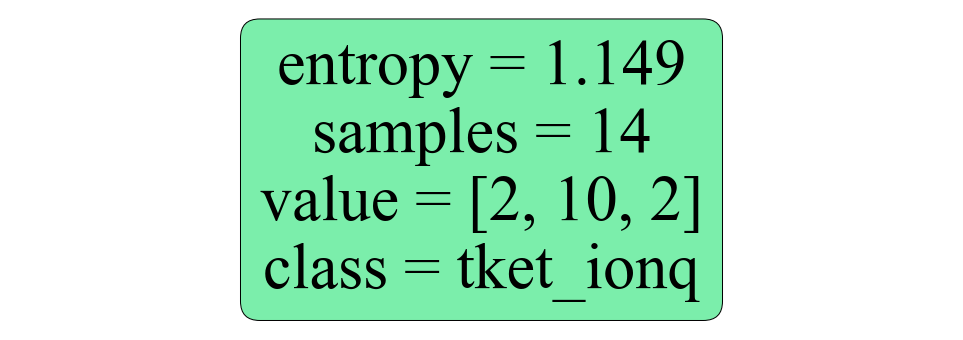

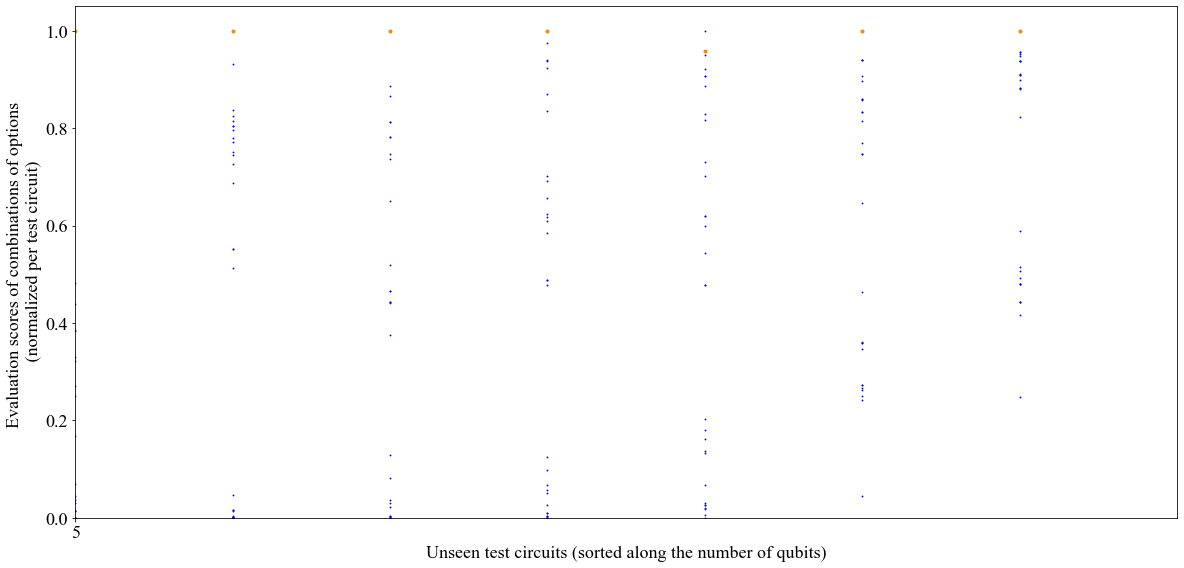

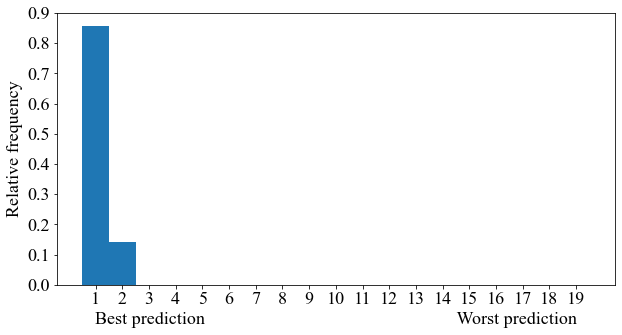

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
X, y = zip(*training_data)
Predictor.train_decision_tree_classifier(X, y, names_list, scores_list);